# Hyperparameter Tuning

## Experiment
The goal of the third experiment is to find the best combination of hyperparameters across a range of different regressor models. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Level-2A Sentinel 2 satellite imagery and indices are used as input features, using the reducers and numbers of composites determined by the previous experiment.
- The evaluation metric for the models is RMSE (Root Mean Squared Error).

The hyperparameter optimization is done using Bayesian Optimization with Optuna. The optuna studies and the best pipeline obects are saved using dill instead of pickle to support lambda functions.

At first we train a baseline model using simple data. We use a random forest model with default parameters and use all spectral Level-2A bands (starting with "B") averaged across the study timewindow as the data:

In [1]:
# Create a baseline composite from a Sentinel image with the average across 1 year
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error

data_path = "../data/processed/hyperparameter_tuning/data_mean_1.tif"
target_path = "../data/processed/target.tif"

# Create the composite if it does not exist
if not Path(data_path).exists():
    Path(data_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=data_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
    )

In [2]:
# Cross validate a default random forest regressor
from sklearn.ensemble import RandomForestRegressor
from ltm.features import load_raster
from sklearn.model_selection import cross_validate

scorer = make_scorer(root_mean_squared_error)

data = load_raster(data_path)
target = load_raster(target_path)
data, target = data[target.notna()], target[target.notna()]

cv_result = cross_validate(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    data,
    target,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
)
baseline_score = cv_result["test_score"].mean()

print(f"Baseline RMSE: {baseline_score}")

Baseline RMSE: 0.30600818069664665


We use optuna with `n_jobs=1` for reproducibility. The number of trials is set to 100 for all decision tree ensembles and 500 for the other models.

In [3]:
# Define the metric and load the data
from sklearn.metrics import make_scorer, root_mean_squared_error
from ltm.features import load_raster

# Define the metric
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Load the data
data_path = "../data/processed/data.tif"
target_path = "../data/processed/target.tif"
data = load_raster(data_path)
target = load_raster(target_path)

# Drop rows with NaN in target
data, target = data[target.notna()], target[target.notna()]

In [4]:
# Create save folder and wrapper functions
from pathlib import Path

save_folder = "../models/"
Path(save_folder).mkdir(parents=True, exist_ok=True)


def suggest_categorical(*args, **kwargs):
    return "suggest_categorical", args, kwargs


def suggest_discrete_uniform(*args, **kwargs):
    return "suggest_discrete_uniform", args, kwargs


def suggest_float(*args, **kwargs):
    return "suggest_float", args, kwargs


def suggest_int(*args, **kwargs):
    return "suggest_int", args, kwargs

In [5]:
from skelm import ELMRegressor
from ltm.models import hyperparam_search

elm_default = ELMRegressor(random_state=42)
search_space = [
    suggest_float("alpha", 1e-8, 1e5, log=True),
    suggest_categorical("include_original_features", [True, False]),
    suggest_float("n_neurons", 1, 1000),
    suggest_categorical("ufunc", ["tanh", "sigm", "relu", "lin"]),
    suggest_float("density", 0.01, 0.99),
]

elm_model, elm_study = hyperparam_search(
    elm_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)
elm_model

Files already exist, skipping search: ..\models\ELMRegressor_study.pkl, ..\models\ELMRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 ELMRegressor(alpha=181.50494096104447,
                              density=0.03017823893725209,
                              n_neurons=612.7512809079332, random_state=42,
                              ufunc='sigm'))])

In [6]:
# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsRegressor
from ltm.models import hyperparam_search

knn_default = KNeighborsRegressor(n_jobs=-1)
search_space = [
    suggest_int("n_neighbors", 1, 100),
    suggest_categorical("weights", ["uniform", "distance"]),
    suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
]

knn_model, knn_study = hyperparam_search(
    knn_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)
knn_model

Files already exist, skipping search: ..\models\KNeighborsRegressor_study.pkl, ..\models\KNeighborsRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=563)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_jobs=-1,
                                     n_neighbors=42, weights='distance'))])

In [7]:
# SGD Linear Regression
from sklearn.linear_model import SGDRegressor
from ltm.models import hyperparam_search

sgd_default = SGDRegressor(random_state=42)
search_space = [
    suggest_categorical(
        "loss",
        [
            "squared_error",
            "huber",
            "epsilon_insensitive",
            "squared_epsilon_insensitive",
        ],
    ),
    suggest_float("alpha", 1e-6, 1e5, log=True),
    suggest_float("l1_ratio", 0, 1),
]

sgd_model, sgd_study = hyperparam_search(
    sgd_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)
sgd_model

Files already exist, skipping search: ..\models\SGDRegressor_study.pkl, ..\models\SGDRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=725)),
                ('model',
                 SGDRegressor(alpha=48.39782214129511,
                              l1_ratio=0.2262576032303607, loss='huber',
                              random_state=42))])

In [8]:
# Support Vector Machine
from sklearn.svm import SVR
from ltm.models import hyperparam_search

svr_default = SVR()
search_space = [
    suggest_float("C", 1e-5, 1e5, log=True),
    suggest_float("epsilon", 1e-5, 1e5, log=True),
    suggest_categorical("kernel", ["poly", "rbf", "sigmoid"]),
]

svr_model, svr_study = hyperparam_search(
    svr_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
    always_standardize=True,  # TODO: pack this info into the paper
)
svr_model

Files already exist, skipping search: ..\models\SVR_study.pkl, ..\models\SVR.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 SVR(C=0.37394429636583115, epsilon=5.2877223547544566e-05))])

In [9]:
from sklearn.ensemble import ExtraTreesRegressor
from ltm.models import hyperparam_search

et_default = ExtraTreesRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_float("min_impurity_decrease", 1e-5, 0.5, log=True),
    suggest_categorical("criterion", ["squared_error", "absolute_error"]),
]

et_model, et_study = hyperparam_search(
    et_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)
et_model

Files already exist, skipping search: ..\models\ExtraTreesRegressor_study.pkl, ..\models\ExtraTreesRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 ExtraTreesRegressor(min_impurity_decrease=0.000502785226062706,
                                     n_estimators=155, n_jobs=-1,
                                     random_state=42))])

In [10]:
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from ltm.models import hyperparam_search

hgbr_default = HistGradientBoostingRegressor(random_state=42)
search_space = [
    suggest_int("max_iter", 100, 1000),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_int("max_leaf_nodes", 2, 1000),
    suggest_categorical("l2_regularization", [0, 1e-10, 1e-5, 1e-3, 1e-1, 1]),
]

hgbr_model, hgbr_study = hyperparam_search(
    hgbr_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)
hgbr_model

Files already exist, skipping search: ..\models\HistGradientBoostingRegressor_study.pkl, ..\models\HistGradientBoostingRegressor.pkl


Pipeline(steps=[('model',
                 HistGradientBoostingRegressor(l2_regularization=1e-05,
                                               learning_rate=0.005798925497228454,
                                               max_iter=800, max_leaf_nodes=12,
                                               random_state=42))])

In [11]:
from sklearn.ensemble import RandomForestRegressor
from ltm.models import hyperparam_search

rf_default = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_int("max_depth", 1, 1000),
    suggest_float("max_features", 0.1, 1.0),
    suggest_float("min_samples_split", 1e-5, 0.5, log=True),
    suggest_float("min_samples_leaf", 1e-5, 0.5, log=True),
    suggest_categorical("bootstrap", [True, False]),
    suggest_categorical(
        "criterion",
        [
            "squared_error",
            "poisson",
            "friedman_mse",
        ],  # absolute error is too slow: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    ),
]

rf_model, rf_study = hyperparam_search(
    rf_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)
rf_model

Files already exist, skipping search: ..\models\RandomForestRegressor_study.pkl, ..\models\RandomForestRegressor.pkl


Pipeline(steps=[('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=266,
                                       max_features=0.23526796793347085,
                                       min_samples_leaf=0.003967120067104282,
                                       min_samples_split=0.010786682101063937,
                                       n_estimators=113, n_jobs=-1,
                                       random_state=42))])

In [12]:
from xgboost import XGBRegressor
from ltm.models import hyperparam_search

xgb_default = XGBRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 10, 200),
    suggest_int("max_depth", 1, 20),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_float("gamma", 0, 0.5),
    suggest_int("min_child_weight", 1, 11),
]

xgb_model, xgb_study = hyperparam_search(
    xgb_default,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)
xgb_model

Files already exist, skipping search: ..\models\XGBRegressor_study.pkl, ..\models\XGBRegressor.pkl


Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.02263403330811986,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04202523026242301, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=193, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [13]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

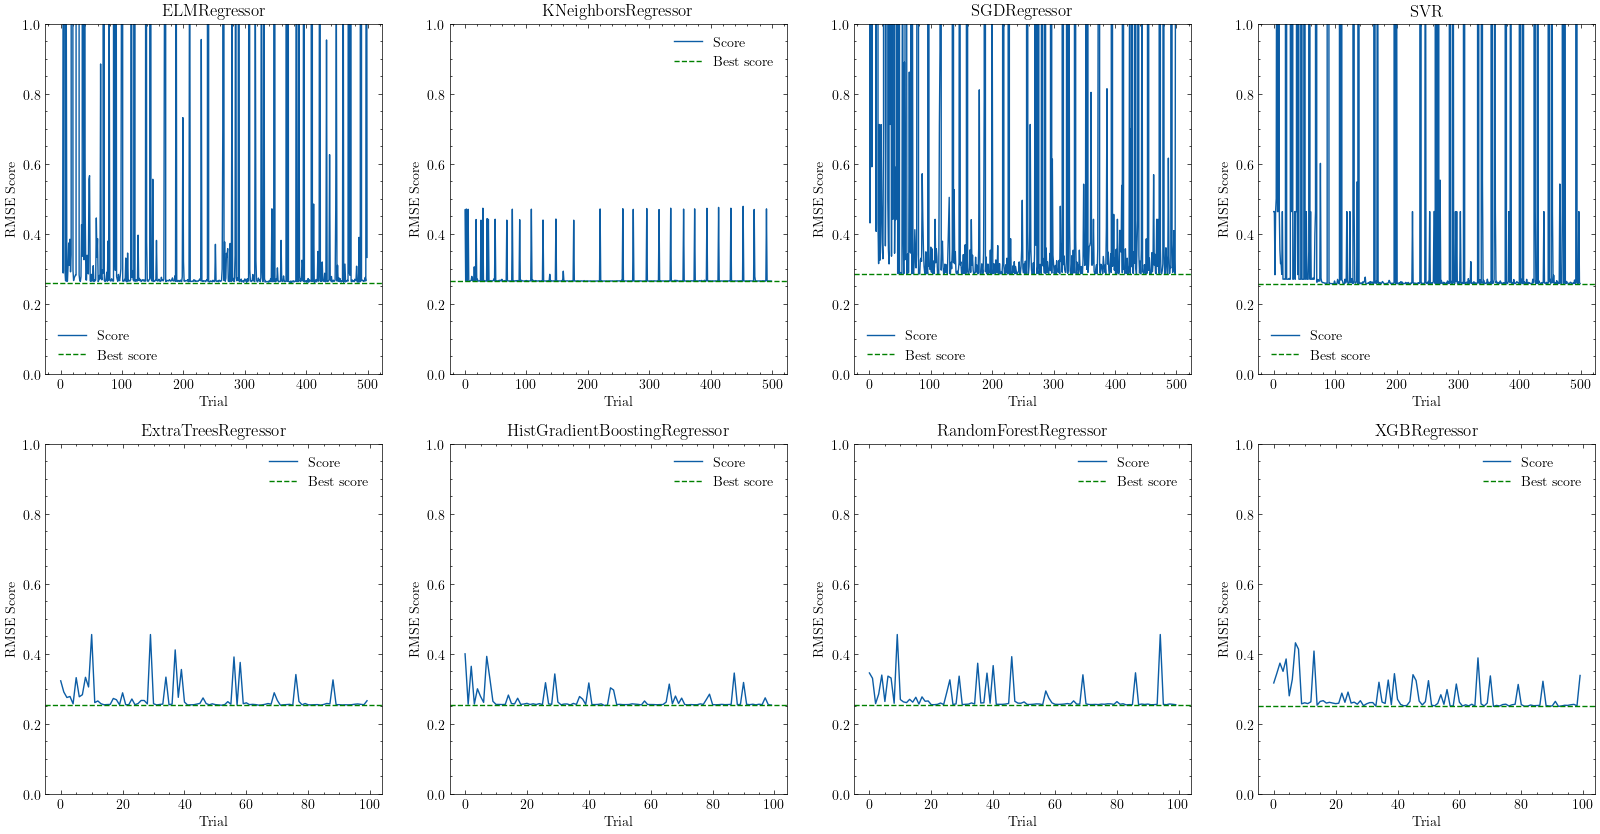

In [14]:
# Plot the hyperparam search scores during search
studies = [
    elm_study,
    knn_study,
    sgd_study,
    svr_study,
    et_study,
    hgbr_study,
    rf_study,
    xgb_study,
]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, study in zip(axs.flat, studies):
    trials = study.trials_dataframe()
    ax.plot(-trials["value"], label="Score")
    ax.set_title(study.study_name)
    ax.set_xlabel("Trial")
    ax.set_ylabel("RMSE Score")
    ax.axhline(-study.best_value, color="g", linestyle="--", label="Best score")
    ax.set_ylim(0, 1)
    ax.legend()

plt.show()

In [15]:
import pandas as pd
from collections import defaultdict
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from tqdm.notebook import tqdm

csv_path = "../reports/hyperparameter_tuning.csv"
scoring = {
    "Mean Absolute Error": make_scorer(mean_absolute_error),
    "Root Mean Squared Error": make_scorer(root_mean_squared_error),
    "R2 Score": make_scorer(r2_score),
}

tuned_models = [
    elm_model,
    knn_model,
    sgd_model,
    svr_model,
    rf_model,
    et_model,
    hgbr_model,
    xgb_model,
]

if not Path(csv_path).exists():
    # Create columns
    model_names = [model.steps[-1][1].__class__.__name__ for model in tuned_models]
    columns = defaultdict(list)
    columns["Model"] = model_names

    # Cross validate default and tuned models
    for model in tqdm(tuned_models):
        cv_result = cross_validate(model, data, target, scoring=scoring, n_jobs=-1)

        for metric in scoring.keys():
            columns[metric].append(cv_result[f"test_{metric}"].mean())

    # Create dataframe
    df = pd.DataFrame(columns)
    df.set_index("Model", inplace=True)
    df.to_csv(csv_path)
else:
    df = pd.read_csv(csv_path, index_col="Model")

# Sort the dataframe by RMSE
df.sort_values("Root Mean Squared Error")

,Mean Absolute Error,Root Mean Squared Error,R2 Score
Model,,,
XGBRegressor,0.158959,0.250168,0.684720
HistGradientBoostingRegressor,0.159579,0.252941,0.677783
ExtraTreesRegressor,0.164691,0.253502,0.677133
RandomForestRegressor,0.166715,0.254584,0.674313
SVR,0.165773,0.258121,0.664555
ELMRegressor,0.183202,0.261034,0.657598
KNeighborsRegressor,0.164553,0.265418,0.646575
SGDRegressor,0.212896,0.286237,0.588798


The best model is the XGBRegressor with a RMSE of 0.251. We visualize the quality of the predictions by predicting the study area using cross validation and plotting the predictions against the actual values.

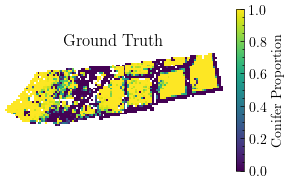

In [16]:
# Plot ground truth
import rasterio
import matplotlib as mpl

# Prepare the colormap
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create subplot and colorbar
fig, ax = plt.subplots()
fig.colorbar(mappable, ax=ax, label="Conifer Proportion", shrink=0.8)

# Load the target raster
with rasterio.open(target_path) as src:
    target_raster = src.read()

# Plot the target raster
ax.imshow(
    target_raster.transpose(1, 2, 0),
    interpolation="nearest",
    cmap=cmap,
    norm=norm,
)
ax.axis("off")
ax.set_title("Ground Truth")

plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

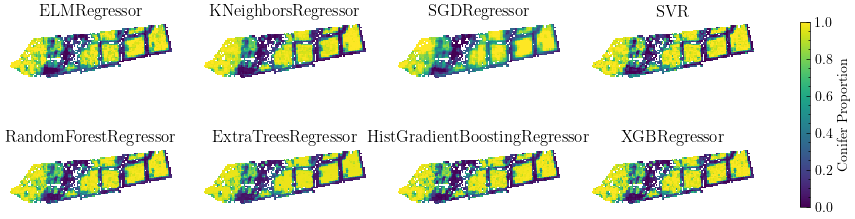

In [17]:
from ltm.models import cv_predict

fig, axs = plt.subplots(2, 4, figsize=(12, 3))
fig.colorbar(mappable, ax=axs, label="Conifer Proportion", shrink=0.8)

prediction_rasters = []
for ax, model in tqdm(list(zip(axs.flatten(), tuned_models))):
    path = f"../data/processed/hyperparameter_tuning/{model.steps[-1][1].__class__.__name__}.tif"
    if Path(path).exists():
        with rasterio.open(path) as src:
            prediction_raster = src.read()
    else:
        prediction_raster = cv_predict(model, data_path, target_path)
        with rasterio.open(target_path) as src:
            profile = src.profile
        
        with rasterio.open(path, "w", **profile) as dst:
            dst.write(prediction_raster)
    
    prediction_rasters.append(prediction_raster)

    im = ax.imshow(
        prediction_raster.transpose(1, 2, 0),
        interpolation="nearest",
        cmap=cmap,
        norm=norm,
    )
    ax.axis("off")
    ax.set_title(model.steps[-1][1].__class__.__name__)

plt.show()

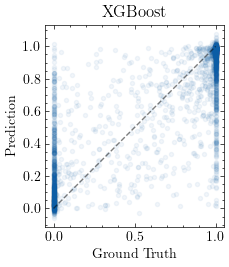

In [18]:
# Plot prediction raster of XGBoost to target raster
best_idx = df["Root Mean Squared Error"].argmin()
plt.plot(target_raster.flatten(), prediction_rasters[best_idx].flatten(), ".", alpha=0.05)
plt.gca().set_aspect("equal")
plt.plot([0, 1], [0, 1], "--", color="k", alpha=0.5)

plt.title("XGBoost")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")

plt.show()

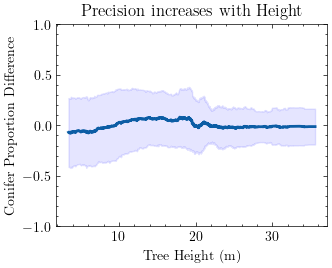

In [27]:
# Plot the difference between the prediction and target raster across the height of the trees
window_size = 200

dem = load_raster("../data/external/dem_median.tif")

target_df = pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = target_df.notna() #& ((target_df == 0) | (target_df == 1))
difference_df = prediction_df - target_df
difference_df, dem_df = difference_df[mask], dem_df[mask]

dem_df = dem_df.reset_index(drop=True)
difference_df = difference_df.reset_index(drop=True)
indices = dem_df.argsort()
difference_df, dem_df = difference_df[indices], dem_df[indices]

difference_mean = difference_df.rolling(window_size).mean()
difference_std = difference_df.rolling(window_size).std()
plt.plot(dem_df, difference_mean, linewidth=2)
plt.fill_between(dem_df, (difference_mean-difference_std), (difference_mean+difference_std), color='b', alpha=.1)
plt.ylim(-1, 1)
plt.xlabel("Tree Height (m)")
plt.ylabel("Conifer Proportion Difference")
plt.title("Precision increases with Height")

plt.show()

Text(0.5, 1.0, 'Endmember Percentage by Height')

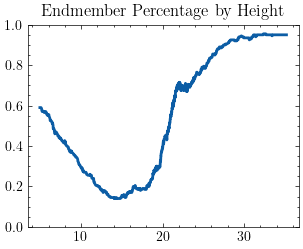

In [20]:
# Plot the percentage of endmembers across the height of the trees
dem = load_raster("../data/external/dem_median.tif")

target_df = pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = (target_df == 0) | (target_df == 1)
endmembers = target_df[mask]
dem_df = dem_df[mask]

dem_df = dem_df.reset_index(drop=True)
endmembers = endmembers.reset_index(drop=True)
indices = dem_df.argsort()
endmembers, dem_df = endmembers[indices], dem_df[indices]
moving_average = endmembers.rolling(window_size).mean()
plt.plot(dem_df, moving_average, linewidth=2)
plt.ylim(0, 1)
plt.title("Endmember Percentage by Height")

plt.show()